# Unpooled MA-IDM

<img src="../Figs/Unpooled_MA_IDM_PGM.png" width="480">

In [1]:
import arviz as az
import numpy as np
import random
import os
import sys
import matplotlib.pyplot as plt

"""
# If pymc3
"""
# import pymc3 as pm
# from theano import tensor as tt
"""
# If pymc4
"""
import pymc as pm
import aesara.tensor as tt

sys.path.append('../')

from data.data_loader import read_training_data
from config import Config
from os import path

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1116)

In [2]:
def formalize_array(x, step, slice_len, skip, sliding_window=True):
    if sliding_window:
        N = int(np.floor((x.shape[0]-slice_len*step+1)/skip))
        x_all = np.zeros((N,slice_len))
        for i in range(N):
            x_all[i,:] = x[i*skip:i*skip+slice_len*step:step]
    else:
        x = x[:: step]
        N = int(np.floor(x.shape[0]/slice_len))
        x_all = np.zeros((N,slice_len))
        for i in range(N):
            x_all[i,:] = x[slice_len*i:slice_len*(i+1)]
    return x_all

def load_training_data(base_path, step, min_traj_lenth, skip, pair_id_list):
    tracks = read_training_data(base_path=base_path, min_traj_lenth=min_traj_lenth)
    
    slice_len=int(4/(step*Config.dt))
    pair_id = pair_id_list
    vt = formalize_array(tracks[pair_id]['vFollReal'], step, slice_len, skip)
    s = formalize_array(tracks[pair_id]['sReal'], step, slice_len, skip)
    dv = formalize_array(tracks[pair_id]['dvReal'], step, slice_len, skip)
    label_v = formalize_array(tracks[pair_id]['vFollReal_next'], step, slice_len, skip)
    
    print("Traj lenth:",min_traj_lenth*Config.dt, ", ID list:", pair_id_list, ", Data size:", label_v.shape)
    return vt, s, dv, label_v

def MA_IDM_unpool(base_path, step):
    # load interactive data for car
    vt, s, dv, label_v = load_training_data(base_path, step, min_traj_lenth=50 * Config.frame_rate_orignial,
                                           skip=3, pair_id_list=Config.truck_interactive_pair_list[0])
    
    print("training size:", label_v.shape)
    
    dt = Config.dt

    model = pm.Model()

    D = 5
    
    slice_len=int(4/(step*Config.dt))
    GP_t = np.array(range(slice_len*step))[0::step].reshape(-1,1)
    shh = GP_t.shape[0]
    
    with model:
        def IDM_v(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
            sn = DSAFE + vt * TSAFE + vt * dv / (2 * tt.sqrt(AMAX * AMIN))
            a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
            return vt + a * Config.dt
        
        s_ = pm.ConstantData("s", s)
        vt_ = pm.ConstantData("vt", vt)
        dv_ = pm.ConstantData("dv", dv)
        
        mu_prior = pm.floatX(np.array([0,0,0,0,0]))
        parameters_normalized = pm.MvNormal('mu_normalized', mu_prior, chol=np.eye(D))
        
        log_parameters = pm.Deterministic('log_mu', parameters_normalized*np.array([.3, 1., 1., .01, .5])
                                      +np.array([2., 0.69, 0.47, -.3, .51]))
        
        parameters = pm.Deterministic('mu', tt.exp(log_parameters))
        
        DELTA = 4 
        
        #################################################
        # priors on the covariance function hyperparameters
        l = pm.Normal('l', mu=1*Config.frame_rate, sigma=1*Config.frame_rate)
        
        # prior on the function variance
        s2_f = pm.Exponential('s2_f', lam=5e4)
        #################################################
       
        s2_a = pm.Exponential('s2_a', lam=1e5)
        
        # covariance functions for the function f and the noise
        cov_func = pm.gp.cov.ExpQuad(1, l)
        cov_obs = dt**2 * (s2_f* cov_func(GP_t)+ s2_a*tt.eye(shh))
        
        v_obs = pm.MvNormal('obs', mu=IDM_v(parameters[0], parameters[1], parameters[2], parameters[3],
                                            parameters[4],DELTA, s_, vt_, dv_), cov=cov_obs, observed=label_v)
        
        tr = pm.sample(draws=2500, tune=5000, random_seed=16, init='jitter+adapt_diag_grad', chains=1,
                       cores=8, discard_tuned_samples=True, return_inferencedata=True, target_accept=0.90)
    return tr, model

In [3]:
base_path = '../data/highD/'
step = 1
tr, model = MA_IDM_unpool(base_path, step)

Traj lenth: 250.0 , ID list: 3 , Data size: (100, 20)
training size: (100, 20)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_normalized, l, s2_f, s2_a]


Sampling 1 chain for 5_000 tune and 2_500 draw iterations (5_000 + 2_500 draws total) took 38 seconds.


In [4]:
import pickle
from pickle import UnpicklingError
base_path = '../data/highD/'
step = 1

cache = "../PGM_highD/cache/MA_IDM_unpooled_truck.pkl"
if path.exists(cache):
    try:
        fp = open(cache, 'rb')
        tr = pickle.load(fp)
        fp.close()
        print("Load trace", cache, ": done!")
    except UnpicklingError:
        os.remove(cache)
        print('Removed broken cache:', cache)
else:
    output_file = open(cache, 'wb')
    pickle.dump(tr, output_file)
    output_file.close()
    print("Generated and Saved", output_file, ": done!")

Generated and Saved <_io.BufferedWriter name='../PGM_highD/cache/MA_IDM_unpooled_truck.pkl'> : done!


In [5]:
print(np.sqrt(tr.posterior.s2_a.mean(axis=0).mean(axis=0)))
print(np.sqrt(tr.posterior.s2_f.mean(axis=0).mean(axis=0)))
print(tr.posterior.l.mean(axis=0).mean(axis=0)*Config.dt)

<xarray.DataArray 's2_a' ()>
array(0.02176273)
<xarray.DataArray 's2_f' ()>
array(0.10830876)
<xarray.DataArray 'l' ()>
array(1.35368271)


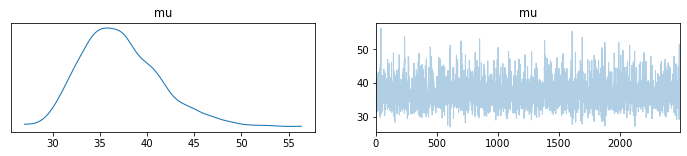

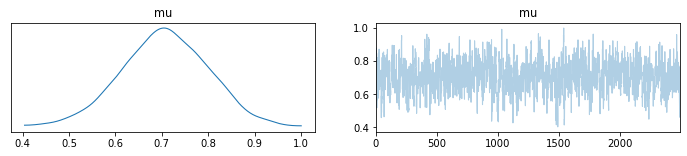

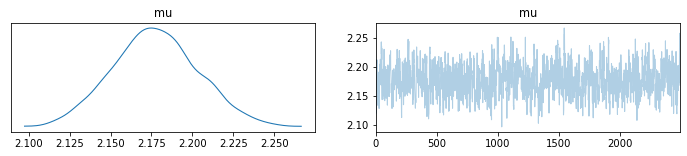

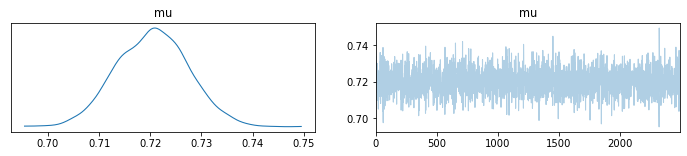

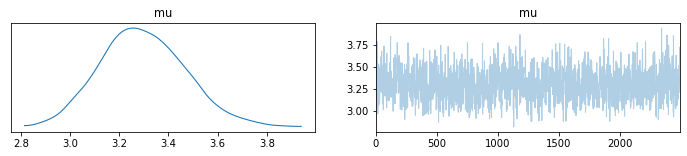

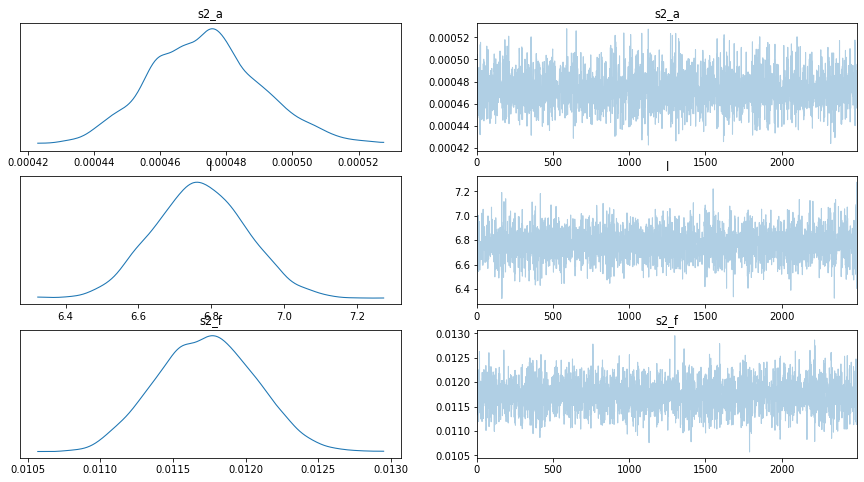

In [6]:
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":0},compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":1}, compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":2}, compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":3}, compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":4}, compact=True)
# _ = az.plot_trace(tr, var_names=["alpha"], compact=True)
_ = az.plot_trace(tr, var_names=["s2_a","l","s2_f"],figsize=(15,8), compact=True)

In [8]:
az.summary(tr, var_names=["mu","log_mu","s2_a", "l", "s2_f"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],37.223,4.232,29.974,45.326,0.074,0.054,3604.0,1998.0,NaN
mu[1],0.707,0.094,0.531,0.883,0.004,0.003,643.0,787.0,NaN
mu[2],2.178,0.026,2.128,2.227,0.001,0.001,572.0,804.0,NaN
mu[3],0.720,0.007,0.707,0.733,0.000,0.000,3428.0,1997.0,NaN
mu[4],3.297,0.171,2.986,3.620,0.006,0.004,930.0,1584.0,NaN
log_mu[0],3.611,0.111,3.409,3.822,0.002,0.001,3604.0,1998.0,NaN
log_mu[1],-0.356,0.136,-0.623,-0.115,0.005,0.004,643.0,787.0,NaN
log_mu[2],0.778,0.012,0.755,0.800,0.001,0.000,572.0,804.0,NaN
log_mu[3],-0.328,0.010,-0.345,-0.309,0.000,0.000,3428.0,1997.0,NaN
log_mu[4],1.192,0.052,1.094,1.286,0.002,0.001,930.0,1584.0,NaN


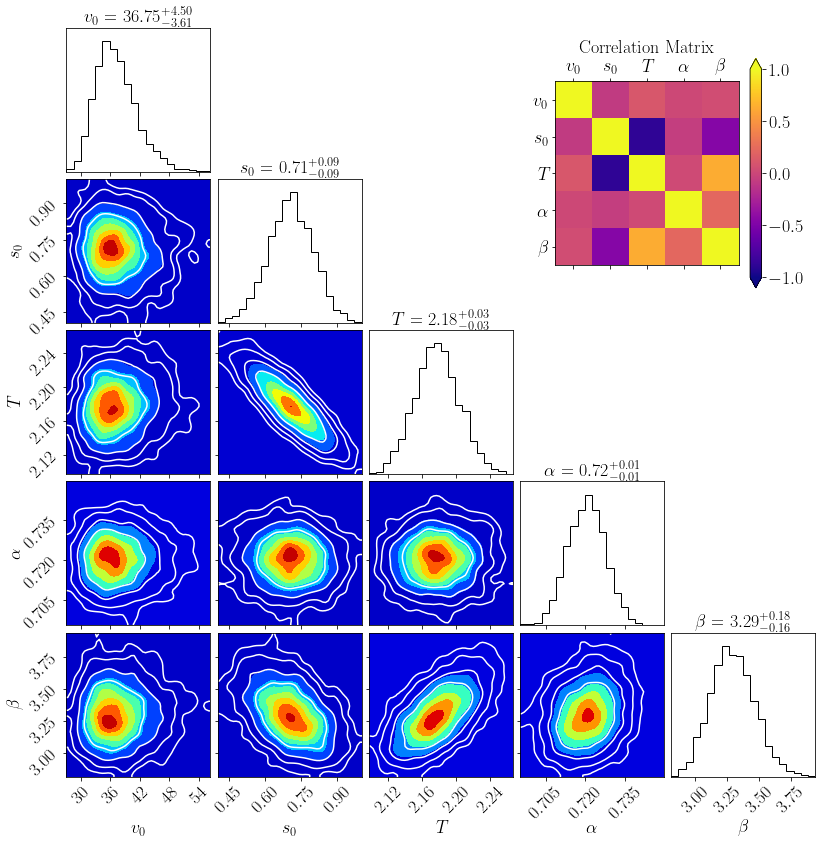

In [9]:
import corner
import matplotlib

label_list = [r'$v_0$',r'$s_0$', r'$T$', r'$\alpha$', r'$\beta$']
fontsize = 18
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

figure = corner.corner(
    tr,
    var_names=['mu'],
    smooth=1.8,
    color = 'k',
    plot_contours=True,
    plot_density=False,
    plot_datapoints = False,
    bins = 20,
    show_titles=True,
    labels=label_list,
    reverse=False,
)

ax_new = figure.add_axes([.66, .66, .27, .27])
cov = np.cov(tr.posterior.mu[0,:,:], rowvar=False)
Dinv = np.diag(1 / np.sqrt(np.diag(cov)))
corr = Dinv @ cov @ Dinv
kwargs = {'cmap':'plasma','interpolation':'nearest', 'vmin':-1}
corr_show = ax_new.matshow(corr, **kwargs)
c_bar = figure.colorbar(corr_show, ax=ax_new, extend='both')
ax_new.set_xticklabels(['']+label_list)
ax_new.set_yticklabels(['']+label_list)
ax_new.set_title('Correlation Matrix')
for item in ([ax_new.title, ax_new.xaxis.label, ax_new.yaxis.label] +
             ax_new.get_xticklabels() + ax_new.get_yticklabels()):
    item.set_fontsize(fontsize)

# figure.savefig('../Figs/GP_IDM_unpool_truck.pdf', dpi=300)

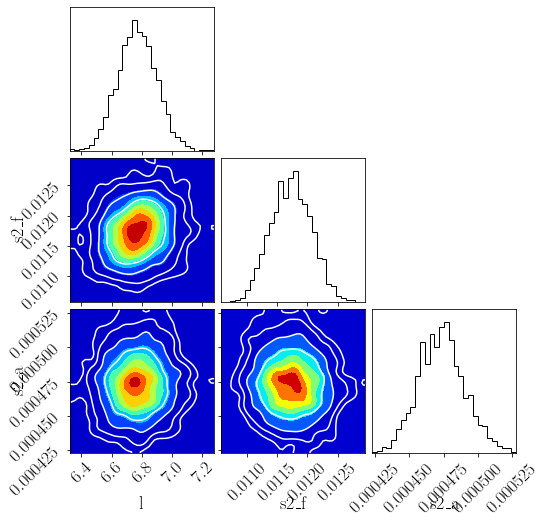

In [10]:
# import corner

_ = corner.corner(
    tr,
    smooth=1.8,
    plot_density=False,
    bins=30,
    var_names=["l", "s2_f", "s2_a"]
)